In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys
from fxpmath import Fxp
import matplotlib.pyplot as plt

In [2]:
dir_current = os.path.abspath('')
dir_parent  = os.path.dirname(dir_current)
if not dir_parent in sys.path: sys.path.append(dir_parent)

In [3]:
from models import Weight_Quantization, Quantization_layer, VGG16_body
from functions import VGG_resize_v2, get_all_outputs, load_obj, save_obj

## Loading Dataset

In [4]:
def normalize(x_):
    return tf.cast(x_, tf.float32) / 255.

In [5]:
x_test,  _  = tfds.as_numpy(tfds.load('deep_weeds', split='train[85%:90%]', batch_size=-1, as_supervised=True))
del _
# Cuantizacion
x_test = Quantization_layer(x_test)


test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.map(normalize)
test_dataset = test_dataset.map(VGG_resize_v2)

## Loading Quantized model

In [6]:
Frac_Bits = 6
Int_Bits  = 5
Nclasses  = 9

Qinput_layer  = tf.keras.Input((224,224,3))
Qoutput_layer = VGG16_body(Qinput_layer, Quantization = True, word_size = (Frac_Bits+Int_Bits+1), frac_size = Frac_Bits, N_labels = Nclasses)
QVGG16 = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [7]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'WeedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

QVGG16.load_weights(Wgt_dir)

## Quantize weights

In [8]:
Weight_Quantization(model = QVGG16, Frac_Bits = 8, Int_Bits = 3)

## Experiment over Layers

In [ ]:
Layers      = [(1,'Input'),(3,'Conv1'),(5,'Relu1'),(7,'Conv2'),(9,'Relu2'),(10,'MP1'),(12,'Conv3'),(14,'Relu3'),
              (16,'Conv4'),(18,'Relu4'),(19,'MP2'),(21,'Conv5'),(23,'Relu5'),(25,'Conv6'),(27,'Relu6'),(29,'Conv7'),
              (31,'Relu7'),(32,'MP3'),(34,'Conv8'),(36,'Relu8'),(38,'Conv9'),(40,'Relu9'),(42,'Conv10'),(44,'Relu10'),
              (45,'MP4'),(47,'Conv11'),(49,'Relu11'),(51,'Conv12'),(53,'Relu12'),(55,'Conv13'),(57,'Relu13'),(58,'MP5'),
              (61,'Dense1'),(63,'Relu14'),(65,'Dense2'),(67,'Relu15'),(69,'Dense3'),(71,'Softmax')]

batch  = 10
for idx in range(len(Layers)):
    activations= []
    iterator   = iter(test_dataset)
    image      = next(iterator)
    for im_index in range(batch):
        outputs   = get_all_outputs(QVGG16, tf.expand_dims(image,axis=0))
        layer_out = outputs[Layers[idx][0]]
        activations.extend(Fxp(layer_out.flatten(),True,12,6).bin())
        image = next(iterator)
    Dict       = {11:0, 10:0, 9:0, 8:0, 7:0, 6:0, 5:0, 4:0, 3:0, 2:0, 1:0, 0:0}
    bit = 0
    while bit < 12:
        Dict[bit] = [item[bit] for item in activations].count("1")/len(activations)
        bit += 1
    save_obj(Dict,'Layers_Stats/Weed_Dataset/' + Layers[idx][1])
    print(Layers[idx][1],'Procesada')     

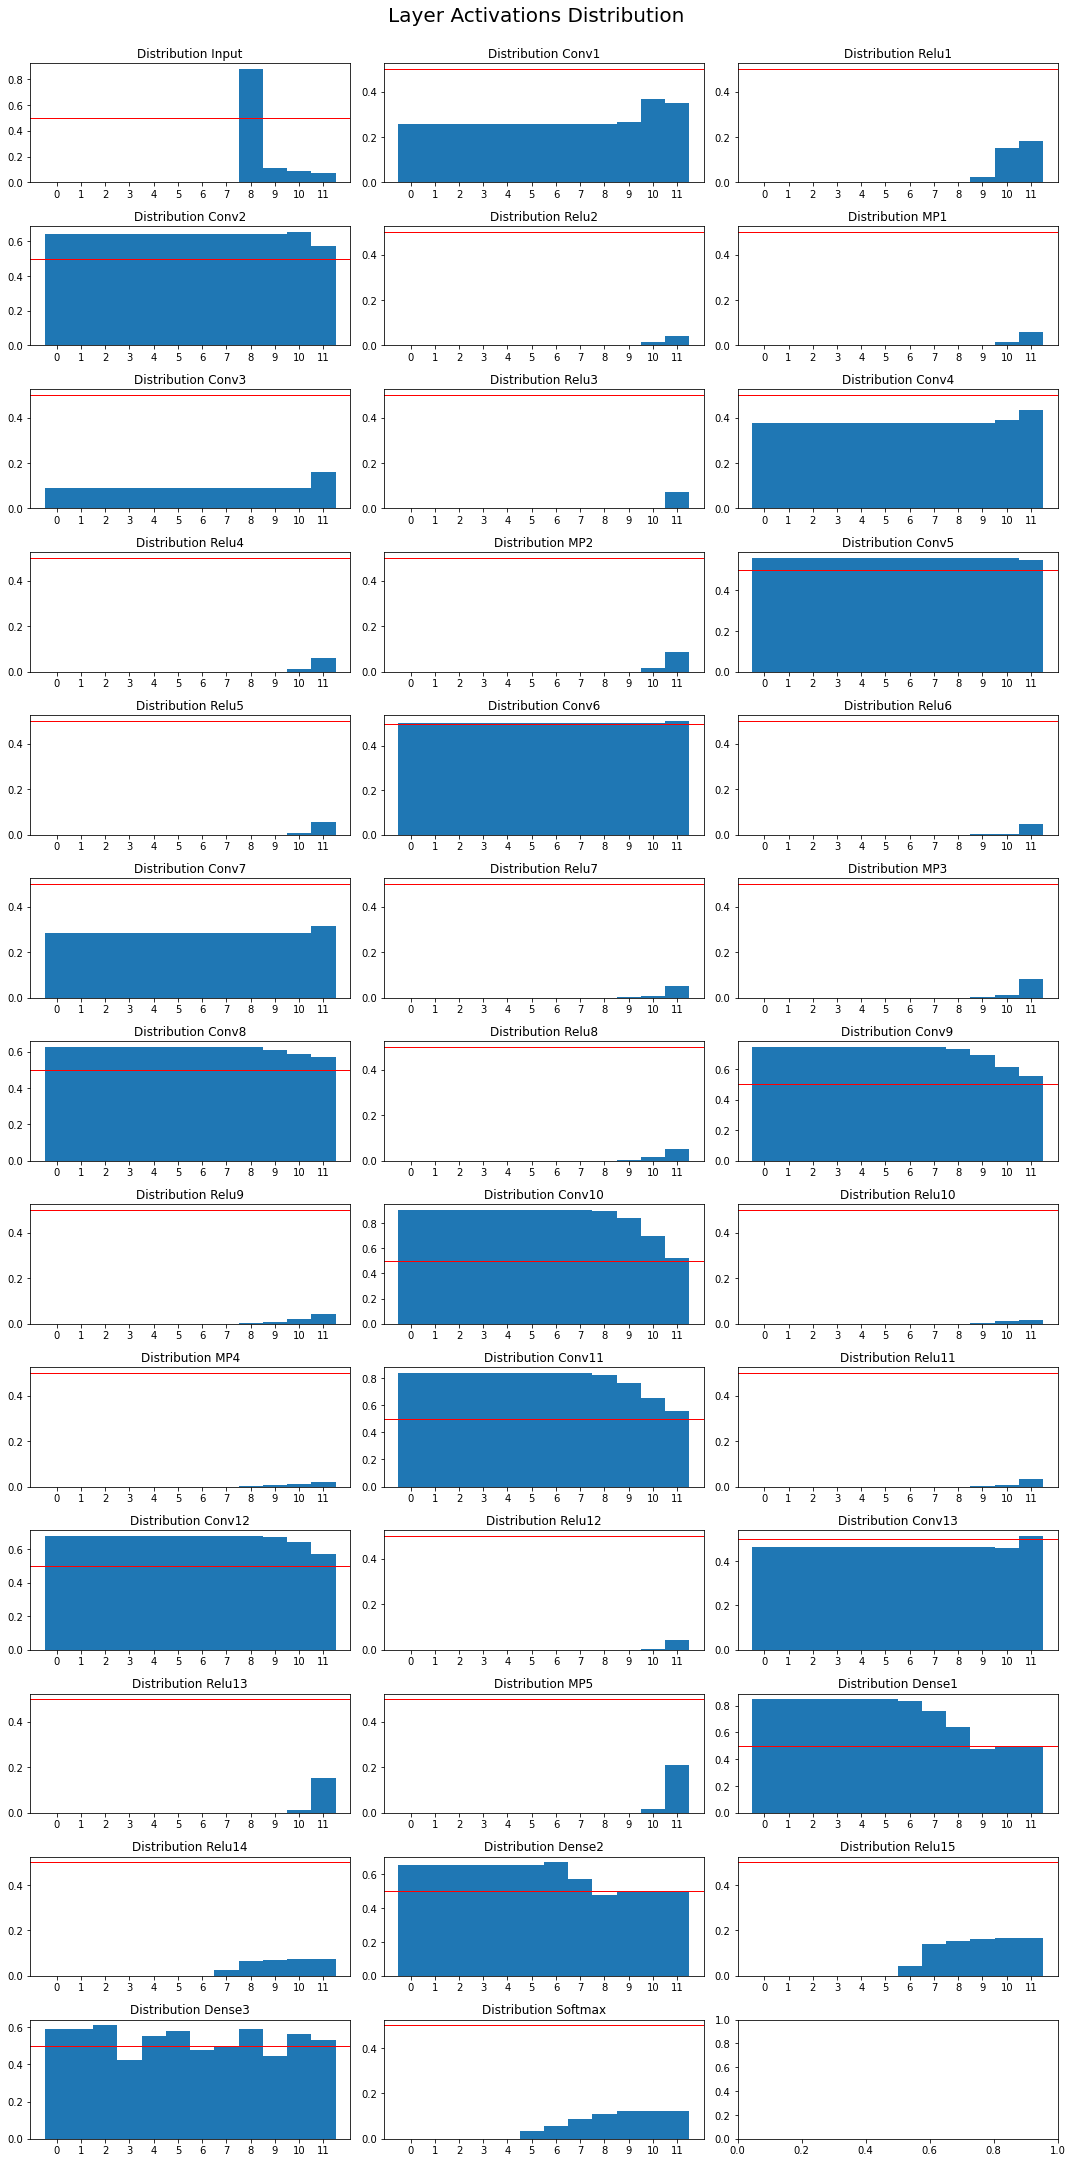

In [27]:
fig, axs = plt.subplots(13,3,figsize=(15,30))
fig.suptitle('Layer Activations Distribution',fontsize=20, y=1)
for row in range(13):
    for col in range(3):
        if 3*row + col < 38:
            Dict = load_obj('Layers_Stats/Weed_Dataset/' + Layers[row*3 + col][1])
            axs[row,col].bar(Dict.keys(), Dict.values(), 1)
            axs[row,col].set_title('Distribution ' + Layers[row*3 + col][1])
            axs[row,col].axhline(y=0.5,linewidth=1, color='r')
            axs[row,col].set_xticks(np.array(list(Dict.keys()),dtype=float))
            axs[row,col].set_xticklabels(Dict.keys())
plt.tight_layout()